# 1. Loading & Introduction of 2 datasets

To explore supervised learning techniques in a practical manner and gain more sights about how they perform in different situations, I herein choose two classification problems with distinct properties of data for my analysis.    
  
The first problem, finding high income individuals is inspired by Udacity’s  Finding Donors for CharityML project, the respect dataset originates from the UCI Machine Learning Repository. It was first introduced in 1996 by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid". I simplify the classification task as **predicting individuals with income more than 50K USD from demographic statistics**, which is imbalanced binary classification with originally 8 categorical features and 5 numerical features on 45K entries.  The second dataset is collected and processed from commercial website  TMDB via its API, it has a mixture of data types: time series, categories, texts and numbers which allow flexible feature extracting. I am interesting to **predict whether a movie is above-average profitable** or not based on features such as cast, director, runtime, etc. Essentially, it’s a balanced binary classification problem on a relatively small dataset (6K entries) with hybrid features.  

In [23]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

data = pd.read_csv("census.csv")   
data2 = pd.read_csv("tmdb-movies.csv")

**Why interesting?**   
  
I believe the choice of datasets allows an interesting comparison of the 5 models, in particular Multi-Layer Perceptron, Decision Tree, K Nearest Neighbors, Support Vector Machine and Gradient Boosting, on their response to the dataset balance, scale, and feature heterogenicity. 
Besides, the two classification problems are practically interesting respect to their potential application significance. For example, predicting individuals’ income level would help precise targeting of social program and commercial advertising, and inspecting of features negatively contributing to the expected profit benefits better decision making of the $40 billion worth movie industry. 


## 1.1 Dataset1

In [24]:
data.drop(['native-country'],axis = 1,inplace = True)

print "Size of Dataset1:",data.shape
highincome_ratio = 1.*data['income'][data['income']=='>50K'].shape[0]/data.shape[0]
print "Individuals with income >50k USD:",str(100 * highincome_ratio )+"%"
data.head(1)

Size of Dataset1: (45222, 13)
Individuals with income >50k USD: 24.7843969749%


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,<=50K


## 1.2 Dataset2

In [3]:
# feature engineering

data2['profit'] = data2['revenue_adj'] - data2['budget_adj']
data2 = data2.loc[np.abs(data2['profit']) >= 1].reset_index()

# engineer new features from `release_date`
data2['release_date'] = pd.to_datetime(data2['release_date']) 
data2['release_year'] = data2['release_date'].apply(lambda x: x.month) #lbl
data2['release_week'] = data2['release_date'].apply(lambda x: x.weekofyear) #lbl
data2['release_month'] = data2['release_date'].apply(lambda x: x.month) # one-hot
data2['release_day'] = data2['release_date'].apply(lambda x: x.weekday_name) #one-hot
data2['release_time'] = data2['release_date'].apply(lambda x: x.value) #num

# engineer new features from non-numerical features
data2['title_len'] = data2['original_title'].apply(lambda x: len(x))
data2['has_homepage'] = data2['homepage'].isnull().apply(lambda x: 0 if x == True else 1)
data2['cast_size'] = data2['cast'].apply(lambda x: len(str(x).split("|")))

# tfidf feature extracting
def txt(x):
    x = x[['director','cast','keywords','production_companies','original_title','tagline','overview']]        

    def add_str(ls):
        res = ''
        for i in range(len(ls)):
            res += str(ls[i])
        return res

    for i in ['director','cast','keywords','production_companies']:
        x[i] = x[i].apply(lambda x: " ".join(str(x).split("|")))

    text = x.apply(lambda y: add_str(y), axis = 1)   
    return text
data2['txt'] = txt(data2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class Txt_transformer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self,x):
        return x['txt'].values
    
svd = TruncatedSVD(n_components = 40, n_iter=1, random_state=12)

vec = TfidfVectorizer(
    max_features = 5000,strip_accents='unicode',lowercase = True,
    analyzer = 'word', token_pattern = r'\w+', ngram_range = (1, 2), use_idf = True,
    smooth_idf = True, sublinear_tf = True, stop_words = 'english'
)


pi=Pipeline([
    ('Txt_transformer',Txt_transformer()),
    ('tfidf', vec), 
    ('svd', svd)    
])

tfidf_features = pi.fit_transform(data2)

data2.drop(['index','id','imdb_id','release_year','release_date','director','cast','keywords','homepage',
            'production_companies','original_title','tagline','overview','txt',
           'budget_adj','revenue_adj','revenue'],axis = 1, inplace = True)


# display overall infomation about dataset2
print "Size of Dataset2:",(data2.shape[0], data2.shape[1] + tfidf_features.shape[1])
highprofit_ratio = 1. * sum(data2.profit > data2['profit'].median())/data2.shape[0]
print "Movies with vote > {:.2f}: {:.2f}%".format(data2['profit'].median(),100 * highprofit_ratio)
data2.head(1)

Size of Dataset2: (6159, 54)
Movies with vote > 5075429.34: 49.99%


,popularity,budget,runtime,genres,vote_count,vote_average,profit,release_week,release_month,release_day,release_time,title_len,has_homepage,cast_size
0,32.985763,150000000,124,Action|Adventure|Science Fiction|Thriller,5562,6.5,1.254446e+09,24,6,Tuesday,1433808000000000000,14,1,5


# 2. Data Pre-processing 

## 2.1 Dataset1

##### logarithmic transformation of right skewed features    
From explorative data visualization (not shown here), features [`capital-gain`, `capital-loss`] are found to be heavily right skewed. To prevent the input range from being impacted by a few outliers, logarithmic transformation was applied on these two.  

In [25]:
log_features = ['capital-gain','capital-loss']
data[log_features] = data[log_features].apply(lambda x: np.log(x + 1))

##### Normalization of numerical features
To make sure each feature be treated equally by machine learning models regardless of original values, a max-min normalization without changing the respect distributions was taken on all numerical features.  

In [26]:
from sklearn.preprocessing import MinMaxScaler

num_features  = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
data[num_features] = MinMaxScaler().fit_transform(data[num_features])

##### One-hot encoding of catagorical features


In [27]:
labels = data['income'].apply(lambda x: 0 if x=='<=50K' else 1)

cat_features = [x for x in data.columns if x not in num_features and x !='income' and x != 'native-country']
dummy = pd.get_dummies(data[cat_features])

data = data.drop(cat_features + ['income'],axis = 1)

features = pd.concat([data,dummy],axis = 1)

print "Input size",features.shape

Input size (45222, 62)


In [18]:
data.to_csv("census-encoded.csv")

In [14]:
# cat_features
pd.get_dummies(data['native-country']).shape

(45222, 41)

##### Shuffling and splitting the input data

In [28]:
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(labels.values,test_size = 0.0001,random_state = 0,n_iter = 1)

for train_index, test_index in sss:
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = labels.values[train_index], labels.values[test_index]
    
# Show the results of splitting
print "Training set1 size:", X_train.shape
print "Testing set1 size:", X_test.shape

Training set1 size: (45217, 62)
Testing set1 size: (5, 62)


In [29]:
from copy import deepcopy
newdata = pd.DataFrame(deepcopy(X_train))
newdata['lbl'] = pd.Series(y_train)
newdata.to_csv("census-encoded.csv")

In [25]:
cut = int(newdata.shape[0]*0.8)

newX_train = newdata[[0,1,2,3,4]].values[range(cut)]
newX_test = newdata[[0,1,2,3,4]].values[range(cut,newdata.shape[0])]

newTrainingdata = pd.DataFrame(newX_train)
newdata['lbl'] = pd.Series(y_test)
newdata.to_csv("census-encoded.csv")

newy_train = newdata['lbl'].values[range(cut)]
newy_test = newdata['lbl'].values[range(cut,newdata.shape[0])] 

newTestingdata = pd.DataFrame(deepcopy(X_test))
newdata['lbl'] = pd.Series(y_test)
newdata.to_csv("census-encoded.csv")


[[ 0.60273973  0.8         0.          0.          0.39795918]
 [ 0.38356164  0.8         0.          0.          0.36734694]
 [ 0.30136986  0.8         0.          0.          0.19387755]
 ..., 
 [ 0.38356164  0.86666667  0.6823576   0.          0.17346939]
 [ 0.05479452  0.4         0.          0.          0.41836735]
 [ 0.57534247  0.33333333  0.          0.          0.39795918]]


In [ ]:
newdata = pd.read_csv("census-endcoded.csv")   



In [42]:
import time

clf = MLPClassifier(hidden_layer_sizes = (3,),max_iter = 10000)
start = time.time()
clf.fit(newX_train,newy_train)
end = time.time()
training_time = end - start

start = time.time()

end = time.time()
pred = clf.predict(newX_test)
testing_time = end - start

print training_time, testing_time,accuracy_score(pred,newy_test)

0.738400936127 5.29289245605e-05 0.780110497238


In [47]:
import csv
RESULTS = [['apple','cherry','orange','pineapple','strawberry'],['haha','lol']]

with open('ha'+str(time.time())+".csv",'wb') as resultFile:
    wr = csv.writer(resultFile, dialect='excel')
    wr.writerows(RESULTS)

## 2.2 Dataset2

##### One-hot encoding of catagorical features

In [8]:
genres = set()
for i in data2['genres']:
    genres = genres | set(str(i).split('|'))    

for genre in genres:
    data2[genre] = data2.apply(lambda x: 1 if genre in str(x['genres']) else 0, axis = 1)

dummy2 = pd.get_dummies(data2['release_day'])
labels2 = data2.profit.apply(lambda x: 0 if x < data2.profit.median() else 1)

data2.drop(['genres','release_day','profit'],inplace = True, axis = 1)
features2 = pd.concat([data2,dummy2],axis = 1)

X2 = np.hstack([features2,tfidf_features])

##### Normalization of numerical features

In [9]:
X2 = MinMaxScaler().fit_transform(X2)

##### Shuffling and splitting the input data

In [10]:
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(labels2.values,test_size = 0.2,random_state = 0,n_iter = 1)

for train_index, test_index in sss:
    X_train2, X_test2 = X2[train_index], X2[test_index]
    y_train2, y_test2 = labels2.values[train_index], labels2.values[test_index]
    
# Show the results of splitting
print "Training set2 size:", X_train2.shape
print "Testing set2 size:", X_test2.shape

Training set2 size: (4927, 79)
Testing set2 size: (1232, 79)


# 3. Discussion of Multi-colinearity
## 3.1 Dataset1  


In [11]:
# Find features with high colinearity with others
corr = np.corrcoef(X_train,rowvar=0)
w, v = np.linalg.eig(np.nan_to_num(corr))
w_array = [(i,np.abs(w[i]),features.columns[i]) for i in  range(len(w)) if np.abs(w[i]) < 0.01]
w_array

[(82, 6.0090905647786928e-16, 'native-country_ Ireland'),
 (83, 1.2567615582479838e-15, 'native-country_ Italy'),
 (84, 1.0410288949374249e-16, 'native-country_ Jamaica'),
 (85, 1.0410288949374249e-16, 'native-country_ Japan'),
 (86, 3.2943899452815283e-16, 'native-country_ Laos'),
 (87, 6.4053921191257975e-16, 'native-country_ Mexico'),
 (88, 8.2282444336890723e-16, 'native-country_ Nicaragua'),
 (100, 3.4027977654855259e-17, 'native-country_ United-States'),
 (101, 3.4027977654855259e-17, 'native-country_ Vietnam'),
 (102, 0.0, 'native-country_ Yugoslavia')]

In [12]:
# Find features corelated to those features
v_array = np.array([np.abs(v[:,i]) for i,x,name in w_array])
table = v_array > 0.25

total_corr_features = set()

for i in range(len(table)):
    corr_features = [j for j in range(len(table[i])) if table[i][j]== True]
    print 'For {}th feature"'.format(w_array[i][0]), w_array[i][2],'", correlated features are:', corr_features
    total_corr_features = total_corr_features | set(corr_features)
    

For 82th feature" native-country_ Ireland ", correlated features are: [1, 21, 24]
For 83th feature" native-country_ Italy ", correlated features are: [35, 37, 38, 42, 44, 46]
For 84th feature" native-country_ Jamaica ", correlated features are: [28, 30, 32, 49, 50, 59]
For 85th feature" native-country_ Japan ", correlated features are: [28, 30, 32, 49, 50, 59]
For 86th feature" native-country_ Laos ", correlated features are: [6, 7, 9, 10]
For 87th feature" native-country_ Mexico ", correlated features are: [23, 27, 57, 59]
For 88th feature" native-country_ Nicaragua ", correlated features are: [49, 50, 57, 59]
For 100th feature" native-country_ United-States ", correlated features are: [28, 30, 32, 49]
For 101th feature" native-country_ Vietnam ", correlated features are: [28, 30, 32, 49]
For 102th feature" native-country_ Yugoslavia ", correlated features are: [76]


In [13]:
[(i,features.columns[i])  for i in total_corr_features]

[(1, 'education-num'),
 (6, 'workclass_ Local-gov'),
 (7, 'workclass_ Private'),
 (9, 'workclass_ Self-emp-not-inc'),
 (10, 'workclass_ State-gov'),
 (76, 'native-country_ Holand-Netherlands'),
 (21, 'education_level_ Bachelors'),
 (23, 'education_level_ HS-grad'),
 (24, 'education_level_ Masters'),
 (27, 'education_level_ Some-college'),
 (28, 'marital-status_ Divorced'),
 (30, 'marital-status_ Married-civ-spouse'),
 (32, 'marital-status_ Never-married'),
 (35, 'occupation_ Adm-clerical'),
 (37, 'occupation_ Craft-repair'),
 (38, 'occupation_ Exec-managerial'),
 (42, 'occupation_ Other-service'),
 (44, 'occupation_ Prof-specialty'),
 (46, 'occupation_ Sales'),
 (49, 'relationship_ Husband'),
 (50, 'relationship_ Not-in-family'),
 (57, 'race_ Black'),
 (59, 'race_ White')]

## 3.2 Dataset2

In [14]:
# Find features with high colinearity with others
corr = np.corrcoef(X_train2,rowvar=0)
w, v = np.linalg.eig(np.nan_to_num(corr))
w_array = [(i,np.abs(w[i])) for i in  range(len(w)) if np.abs(w[i]) < 0.01]
w_array

[(9, 9.3405417176561221e-16), (78, 0.0)]

In [15]:
# Find features corelated to those features
v_array = np.array([np.abs(v[:,i]) for i,x in w_array])
table = v_array > 0.25


total_corr_features = set()

In [16]:
for i in range(len(table)):
    corr_features = [j for j in range(len(table[i])) if table[i][j]== True]
    print 'For {}th feature"'.format(w_array[i][0]), '", correlated features are:', corr_features
    total_corr_features = total_corr_features | set(corr_features)

For 9th feature" ", correlated features are: [32, 33, 34, 36, 37, 38]
For 78th feature" ", correlated features are: [27]


# 4. ROC Curve/AUC on Baseline Models

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc,roc_curve

baseline_prob = [MLPClassifier(random_state=0),DecisionTreeClassifier(random_state=0),KNeighborsClassifier(5),
                 SVC(C = 1,probability=True,random_state=0),GradientBoostingClassifier(random_state=0)]

colors = ['darkorange','red','darkgreen','purple','pink']

## 4.1 Dataset1

In [18]:
rocauc_results = {}
for clf in baseline_prob:
    clf_name = clf.__class__.__name__
    rocauc_results [clf_name] = {'auc':0,'fpr':[],'tpr':[]}
    
    clf.fit(X_train,y_train)
    rocauc_results[clf_name]['fpr'],rocauc_results [clf_name]['tpr'],_ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    rocauc_results[clf_name]['auc'] = auc(rocauc_results[clf_name]['fpr'], rocauc_results [clf_name]['tpr'])

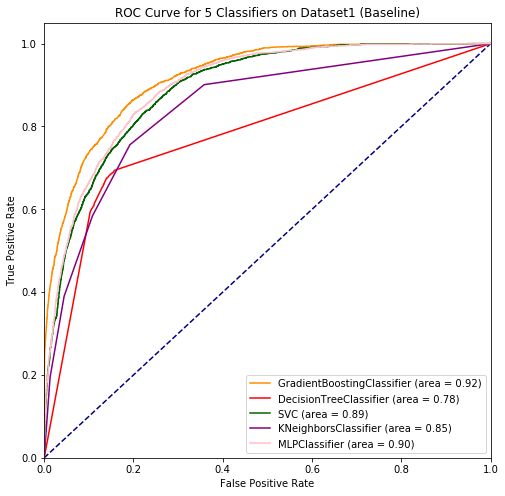

In [19]:
plt.figure(figsize = (8,8))
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')

for i,name in enumerate(rocauc_results.keys()):
    plt.plot(rocauc_results[name]['fpr'], rocauc_results[name]['tpr'], color=colors[i],label='{} (area = {:.2f})'.format(name,rocauc_results[name]['auc']))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve for 5 Classifiers on Dataset1 (Baseline)');
plt.legend(loc="lower right");  

plt.savefig('4.1 ROC Curve for 5 Classifiers on Dataset1 (Baseline).png')

## 4.2 Dataset2

In [20]:
rocauc_results2 = {}
for clf in baseline_prob:
    clf_name = clf.__class__.__name__
    rocauc_results2[clf_name] = {'auc':0,'fpr':[],'tpr':[]}
    
    clf.fit(X_train2,y_train2)
    rocauc_results2[clf_name]['fpr'],rocauc_results2[clf_name]['tpr'],_ = roc_curve(y_test2, clf.predict_proba(X_test2)[:, 1])
    rocauc_results2[clf_name]['auc'] = auc(rocauc_results2[clf_name]['fpr'], rocauc_results2[clf_name]['tpr'])


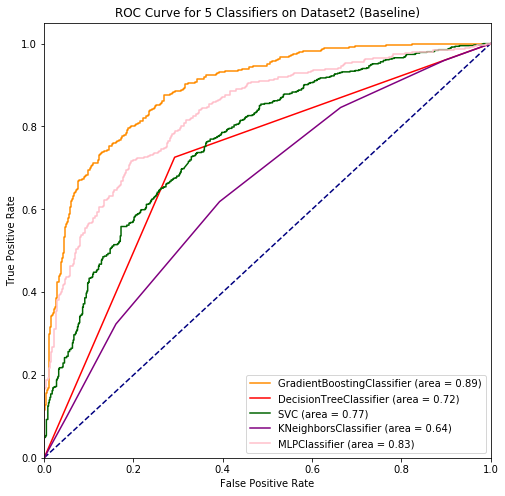

In [21]:
plt.figure(figsize = (8,8))
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')

for i,name in enumerate(rocauc_results2.keys()):
    plt.plot(rocauc_results2[name]['fpr'], rocauc_results2[name]['tpr'], color=colors[i],label='{} (area = {:.2f})'.format(name,rocauc_results2[name]['auc']))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve for 5 Classifiers on Dataset2 (Baseline)');
plt.legend(loc="lower right");  

plt.savefig('4.2 ROC Curve for 5 Classifiers on Dataset2 (Baseline).png')

## 5. Learning Curve on Baseline Models

In [27]:
from sklearn.metrics import accuracy_score
baseline = [MLPClassifier(random_state=0),DecisionTreeClassifier(random_state=0),KNeighborsClassifier(5),
            SVC(C = 1,random_state=0),GradientBoostingClassifier(random_state=0)]

names = [clf.__class__.__name__ for clf in baseline]

## 5.1 Dataset1

In [23]:
learning_curve_samples = []

for i in [1,2,5]:
    learning_curve_samples.append(int(i * X_train.shape[0] / 100.))
    
for i in range(1,11):
    learning_curve_samples.append(int(i * 10 * X_train.shape[0] / 100.))

In [24]:
learningcurve_results = {}
for clf in baseline:
    clf_name = clf.__class__.__name__
    learningcurve_results[clf_name] = {'test':[],'train':[]}
    
    for i, sample in enumerate(learning_curve_samples):
        clf.fit(X_train[:sample],y_train[:sample])
        
        ytest_pred = clf.predict(X_test)
        ytrain_pred = clf.predict(X_train[:sample])
        
        error_test = 1. - accuracy_score(y_test,ytest_pred)
        error_train = 1. - accuracy_score(y_train[:sample],ytrain_pred)
                
        learningcurve_results[clf_name]['test'].append(error_test)
        learningcurve_results[clf_name]['train'].append(error_train) 

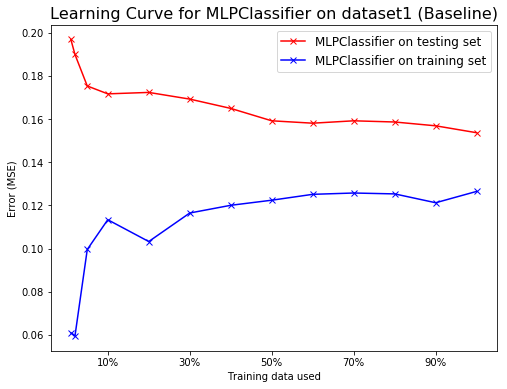

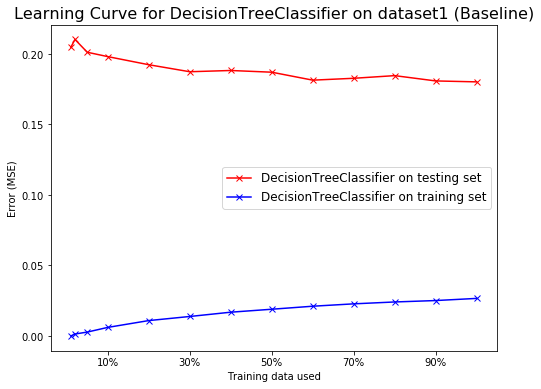

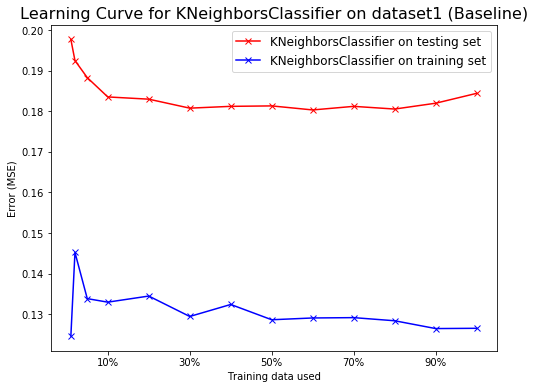

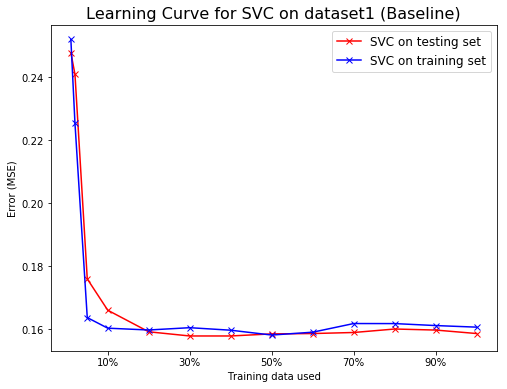

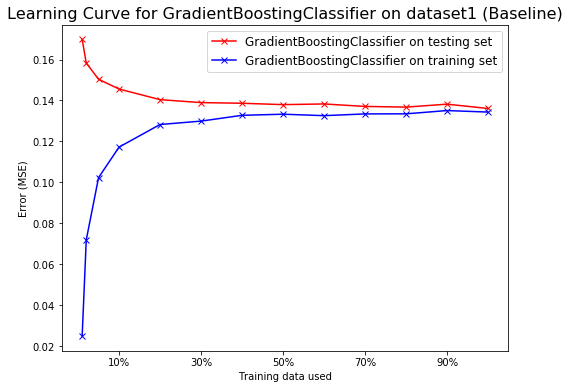

In [25]:
for i in range(5):
    x_data = [1,2,5,10,20,30,40,50,60,70,80,90,100]
    plt.figure(figsize = (8,6))
    plt.title('Learning Curve for {} on dataset1 (Baseline)'.format(names[i]),fontsize = 16)
    plt.plot(x_data,learningcurve_results[names[i]]['test'],'rx-', label = names[i] + ' on testing set' )
    plt.plot(x_data,learningcurve_results[names[i]]['train'],'bx-',label = names[i] + ' on training set')
    
    ticks = [10,30,50,70,90]
    plt.xticks(ticks,[str(x)+"%" for x in ticks])
    plt.xlabel("Training data used")
    plt.ylabel("Error (MSE)")
    plt.legend(loc="best",fontsize = 12);   
    
    plt.savefig("5.1 Learning curve of" + names[i] + 'on testing set.png')

## 5.2 Dataset2

In [26]:
learning_curve_samples2 = []

for i in [1,2,5]:
    learning_curve_samples2.append(int(i * X_train.shape[0] / 100.))
    
for i in range(1,11):
    learning_curve_samples2.append(int(i * 10 * X_train.shape[0] / 100.))

In [27]:
learningcurve_results2 = {}
for clf in baseline:
    clf_name = clf.__class__.__name__
    learningcurve_results2[clf_name] = {'test':[],'train':[]}
    
    for i, sample in enumerate(learning_curve_samples2):
        clf.fit(X_train2[:sample],y_train2[:sample])
        
        ytest_pred2 = clf.predict(X_test2)
        ytrain_pred2 = clf.predict(X_train2[:sample])
        
        error_test2 = 1. - accuracy_score(y_test2,ytest_pred2)
        error_train2 = 1. - accuracy_score(y_train2[:sample],ytrain_pred2)
                
        learningcurve_results2[clf_name]['test'].append(error_test2)
        learningcurve_results2[clf_name]['train'].append(error_train2) 

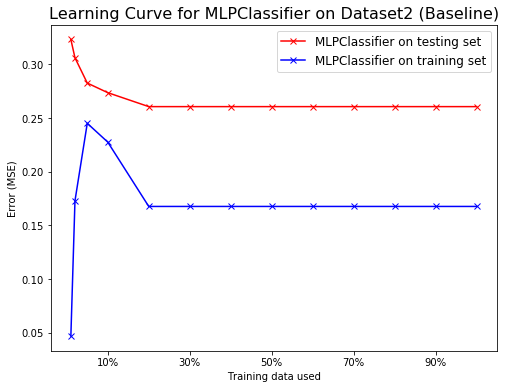

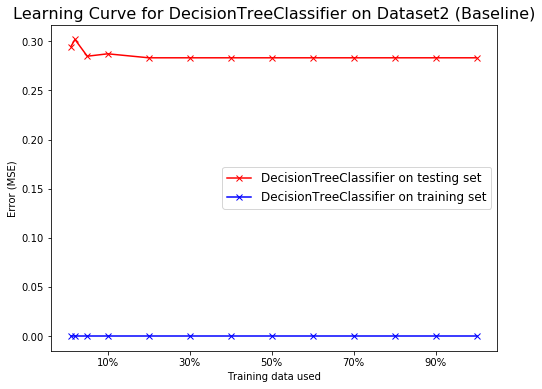

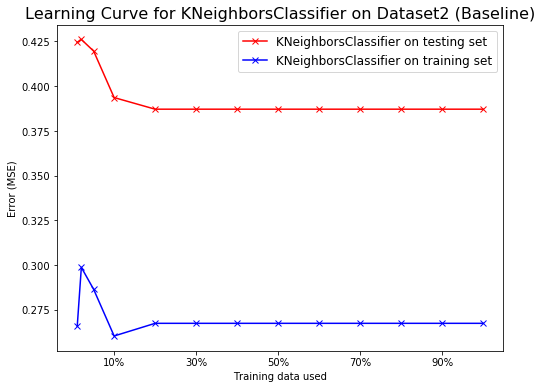

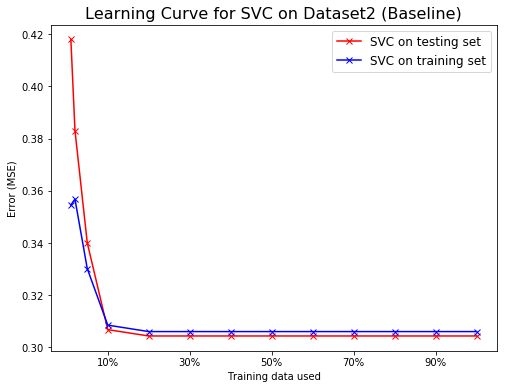

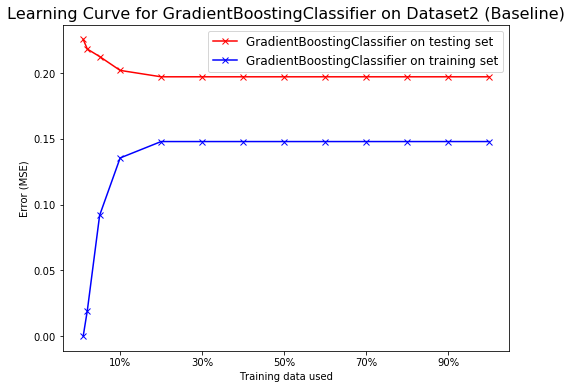

In [28]:
for i in range(5):
    x_data = [1,2,5,10,20,30,40,50,60,70,80,90,100]
    plt.figure(figsize = (8,6))
    plt.title('Learning Curve for {} on Dataset2 (Baseline)'.format(names[i]),fontsize = 16)
    plt.plot(x_data,learningcurve_results2[names[i]]['test'],'rx-', label = names[i] + ' on testing set' )
    plt.plot(x_data,learningcurve_results2[names[i]]['train'],'bx-',label = names[i] + ' on training set')
    
    ticks = [10,30,50,70,90]
    plt.xticks(ticks,[str(x)+"%" for x in ticks])
    plt.xlabel("Training data used")
    plt.ylabel("Error (MSE)")
    plt.legend(loc="best",fontsize = 12);   
    
    plt.savefig("5.2 Learning curve of" + names[i] + 'on testing set.png')

# 6. Model Complexity and Tuning  

In [10]:
# def model_complexity(clf,x_train,y_train,x_test,y_test,
#                      param,param_ls, extra_param = {'random_state':0}):
#     if not param_ls:
#         max_depth = clf(random_state = 0).fit(x_train,y_train).tree_.max_depth
#         param_ls = range(1, max_depth + 1)      
        
#     param_len  = len(param_ls) 
#     results = {'test':[],'train':[]}
#     name = clf().__class__.__name__
    
#     for i in range(param_len):
#         dic = {param:param_ls[i]}
#         if extra_param:
#             dic = dict(dic.items() + extra_param.items())
#         model = clf(**dic)
#         model.fit(x_train,y_train)
        
#         train_error = 1. - accuracy_score(model.predict(x_train),y_train)
#         test_error = 1. - accuracy_score(model.predict(x_test),y_test)
        
#         results['train'].append(train_error)
#         results['test'].append(test_error) 
    
#     opt = pd.Series(results['test']).idxmin() 
#     print "{} when MSE on testing set the lowest:".format(param),param_ls[opt]
#     return name,results,param,param_ls

def model_complexity(clf,x_train,y_train,x_test,y_test,
                     param,param_ls, extra_param = {'random_state':0}):
    if not param_ls:
        max_depth = clf(random_state = 0).fit(x_train,y_train).tree_.max_depth
        param_ls = range(1, max_depth + 1)      
        
    param_len  = len(param_ls) 
    results = {'test':[],'train':[]}
    name = clf().__class__.__name__
    
    print '_outputs_',clf.n_outputs_
    print '_layers_',clf.n_layers_ 
    print '_iter_ ',clf.n_iter_ 
    
    for i in range(param_len):
        dic = {param:param_ls[i]}
        if extra_param:
            dic = dict(dic.items() + extra_param.items())
        model = clf(**dic)
        model.fit(x_train,y_train)
        
        train_error = 1. - accuracy_score(model.predict(x_train),y_train)
        test_error = 1. - accuracy_score(model.predict(x_test),y_test)
        
        results['train'].append(train_error)
        results['test'].append(test_error) 
    
    opt = pd.Series(results['test']).idxmin() 
    print "{} when MSE on testing set the lowest:".format(param),param_ls[opt]
    return name,results,param,param_ls

def display(name,results,param,param_ls,dataset,
           xticks = None, xfont = None, copy = None):
    param_len = len(param_ls)
    plt.figure(figsize = (8,6))
    plt.title('Model Complexity Curve for {} on dataset{}'.format(name,dataset),fontsize = 16)
    
    x_data = range(param_len)
    if name == 'DecisionTreeClassifier':
        x_data = param_ls
         
    plt.plot(x_data,results['train'],'b-',label = 'training set')
    plt.plot(x_data,results['test'],'rx-',label = 'testing set')
    plt.plot(x_data,np.array(results['test']) - np.array(results['train']),'k-', label = 'Error difference between two sets')
    
    opt = pd.Series(results['test']).idxmin()
    plt.scatter(x_data[opt],results['test'][opt], s = 400, c = 'yellow')
    
    plt.xlabel(param)
    plt.ylabel("Error (MSE)")
    if xticks:
        plt.xticks(range(len(param_ls)),xticks,fontsize = xfont)
    plt.legend(loc="best",fontsize = 12)
    
    png_name = '6.{} Model Complexity Curve for {} ({}) on Dataset{}.png'.format(
    dataset,name,param,dataset)    
    if copy:
        png_name.split('.')[0] + copy +'.png'
    plt.savefig(png_name)  

## 6.1 Dataset1

##### MLPClassifier

The smaller alpha, the more complex MLP model, as alpha is a term of l2 penalty. Besides, hidden_layer_sizes can also be used to adjust model complexity. MLP is [sensitive to feature scaling](http://sdsawtelle.github.io/blog/output/week4-andrew-ng-machine-learning-with-python.html)

In [13]:
sizes = [(10,),(50,),(100,),(500,),
        (10,10),(50,50),(100,100),
         (10,10,10),(50,50,50),(100,100,100)]

name, MLP_res,pr,pr_l = model_complexity(MLPClassifier,X_train,y_train,X_test,y_test,
                           'hidden_layer_sizes',sizes);

_outputs_

AttributeError: type object 'MLPClassifier' has no attribute 'n_outputs_'

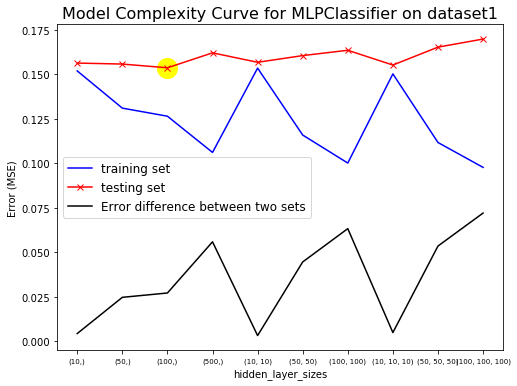

In [31]:
display(name,MLP_res,pr,pr_l,1,
        sizes,7)

In [32]:
name, MLP_res,pr,pr_l = model_complexity(MLPClassifier,X_train,y_train,X_test,y_test,
                           'max_iter',[10,20,50,80,100,150,200],
                                         );

max_iter when MSE on testing set the lowest: 100


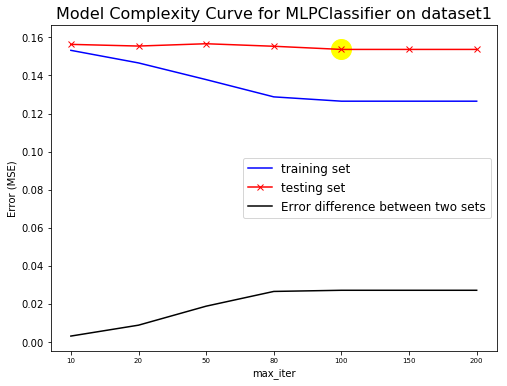

In [33]:
display(name,MLP_res,pr,pr_l,1,
        [10,20,50,80,100,150,200],7)

##### DecisionTreeClassifier

In [34]:
name, DT_res,pr,pr_l = model_complexity(DecisionTreeClassifier,X_train,y_train,X_test,y_test,
                           'max_depth',None);

max_depth when MSE on testing set the lowest: 11


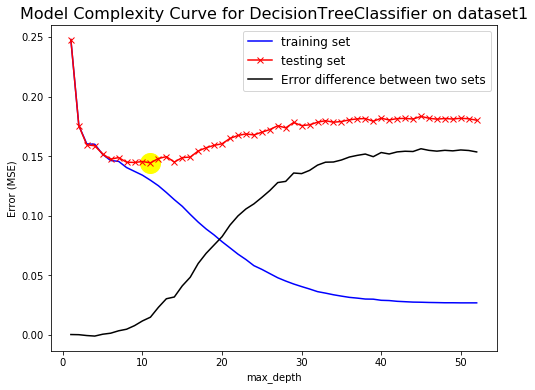

In [35]:
display(name,DT_res,pr,pr_l,1,
       )

##### KNeighborsClassifier

In [36]:
name, KNN_res,pr,pr_l = model_complexity(KNeighborsClassifier,X_train,y_train,X_test,y_test,
                                         'n_neighbors',[3,5,20,50,100,200],
                                         extra_param = None);

n_neighbors when MSE on testing set the lowest: 50


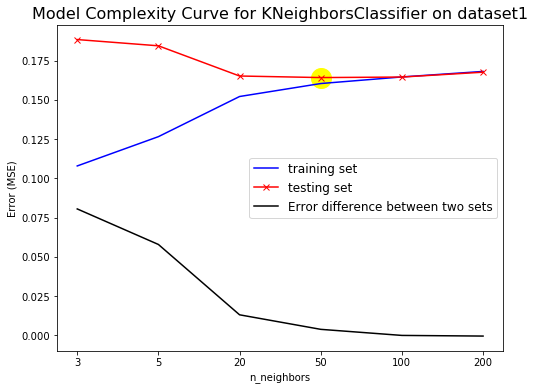

In [37]:
display(name,KNN_res,pr,pr_l,1,
       [3,5,20,50,100,200],)

##### SVC(kernel)

In [38]:
name, svcrbf_res,pr,pr_l = model_complexity(SVC,X_train,y_train,X_test,y_test,
                           'kernel',['linear', 'poly', 'rbf', 'sigmoid']);

kernel when MSE on testing set the lowest: sigmoid


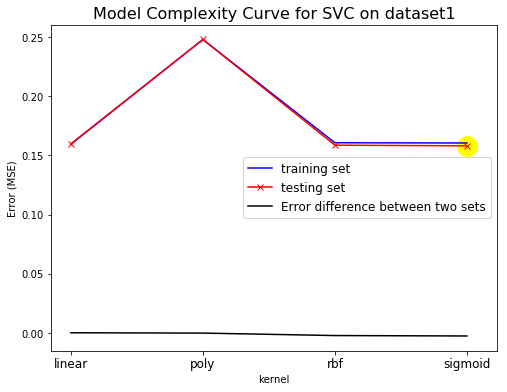

In [39]:
display(name,svcrbf_res,pr,pr_l,1,
        ['linear', 'poly', 'rbf', 'sigmoid'],12)

##### SVC(kernel = linear, C)

In [40]:
name, svcpoly_res,pr,pr_l = model_complexity(SVC,X_train,y_train,X_test,y_test,
                                             'C',[1,5,50],
                                             extra_param = {'kernel':'linear','random_state':0});

C when MSE on testing set the lowest: 50


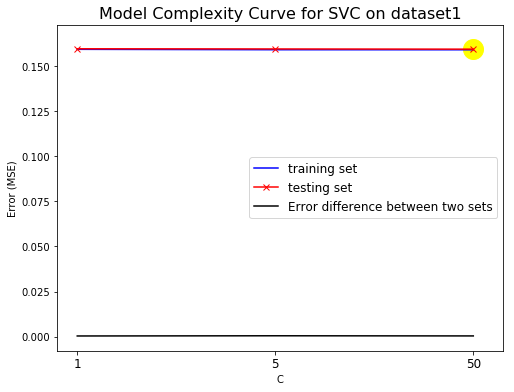

In [41]:
display(name,svcpoly_res,pr,pr_l,1,
        [1,5,50],12,'(linear)')

##### GradientBoostingClassifier


In [42]:
name, GBM_res,pr,pr_l = model_complexity(GradientBoostingClassifier,X_train,y_train,X_test,y_test,
                           'max_depth',range(2,10));

max_depth when MSE on testing set the lowest: 6


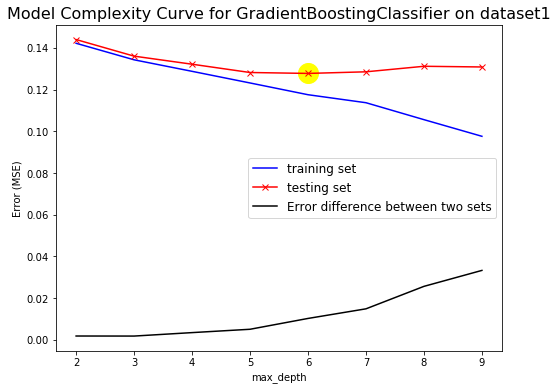

In [43]:
display(name,GBM_res,pr,pr_l,1,
        range(2,10))

## 6.2 Dataset2  
#####  MLPClassifier

In [44]:
sizes = [(10,),(50,),(100,),(500,),
        (10,10),(50,50),(100,100),
         (10,10,10),(50,50,50),(100,100,100)]

name, MLP_res2,pr,pr_l = model_complexity(MLPClassifier,X_train2,y_train2,X_test2,y_test2,
                           'hidden_layer_sizes',sizes);

hidden_layer_sizes when MSE on testing set the lowest: (50,)


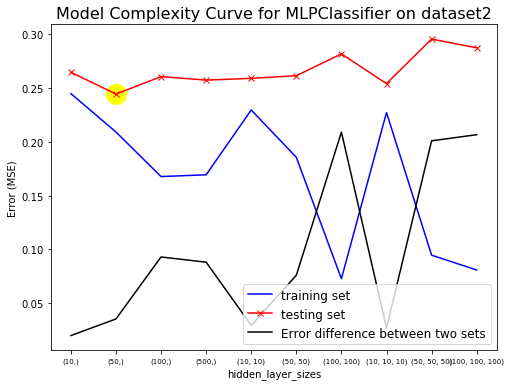

In [45]:
display(name,MLP_res2,pr,pr_l,2,
        sizes,7)

In [46]:
name, MLP_res2,pr,pr_l = model_complexity(MLPClassifier,X_train2,y_train2,X_test2,y_test2,
                           'max_iter',[50,80,100,120,150,170,200],
                                         extra_param = {'alpha':0.01,'hidden_layer_sizes':(5,5)});

max_iter when MSE on testing set the lowest: 170


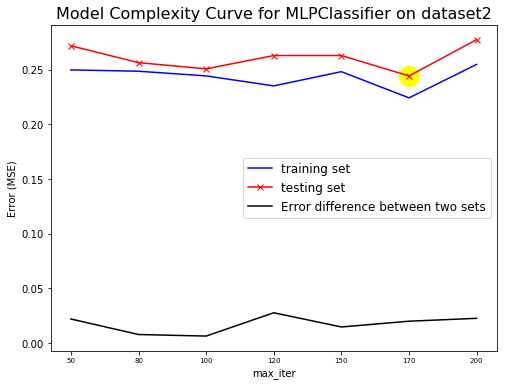

In [47]:
display(name,MLP_res2,pr,pr_l,2,
        [50,80,100,120,150,170,200],7)

##### DecisionTreeClassifier

In [48]:
name, DT_res2,pr,pr_l = model_complexity(DecisionTreeClassifier,X_train2,y_train2,X_test2,y_test2,
                           'max_depth',None);

max_depth when MSE on testing set the lowest: 4


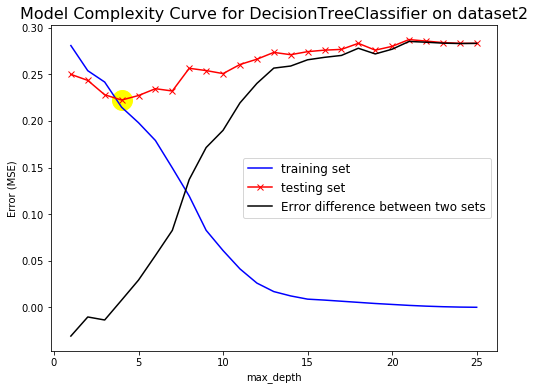

In [49]:
display(name,DT_res2,pr,pr_l,2,
       ) 

##### KNeighborsClassifier

In [50]:
name, KNN_res2,pr,pr_l = model_complexity(KNeighborsClassifier,X_train2,y_train2,X_test2,y_test2,
                                          'n_neighbors',[3,5,20,50,100,200],
                                          extra_param = None);

n_neighbors when MSE on testing set the lowest: 200


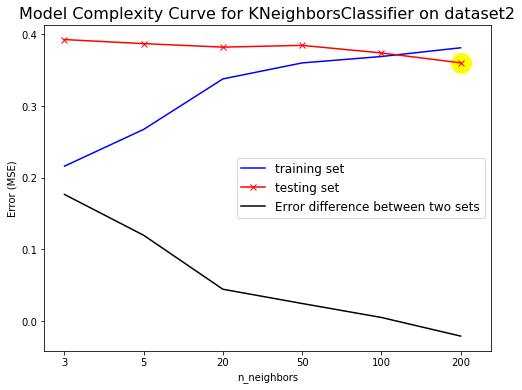

In [51]:
display(name,KNN_res2,pr,pr_l,2,
       [3,5,20,50,100,200],)

##### SVC(kernel)

In [52]:
name, svcrbf_res2,pr,pr_l = model_complexity(SVC,X_train2,y_train2,X_test2,y_test2,
                           'kernel',['linear', 'poly', 'rbf', 'sigmoid'],);

kernel when MSE on testing set the lowest: linear


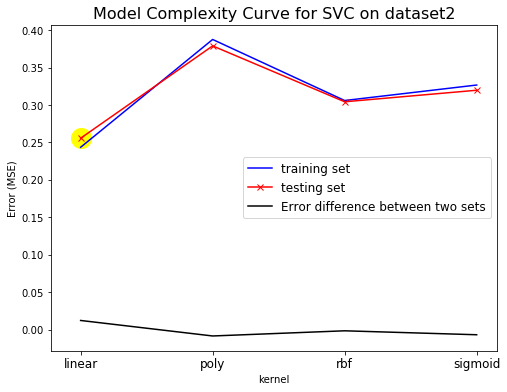

In [53]:
display(name,svcrbf_res2,pr,pr_l,2,
        ['linear', 'poly', 'rbf', 'sigmoid'],12)

##### SVC(kernel = linear, C)

In [54]:
name, svcpoly_res2,pr,pr_l = model_complexity(SVC,X_train2,y_train2,X_test2,y_test2,
                                             'C',[10**i for i in range(5)],
                                             extra_param = {'kernel':'linear','random_state' : 0});

C when MSE on testing set the lowest: 10000


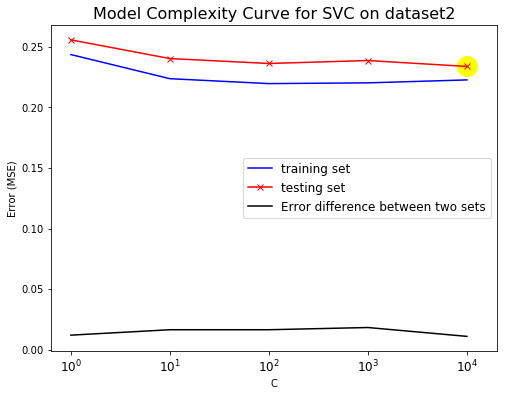

In [55]:
display(name,svcpoly_res2,pr,pr_l,2,
        [ '$10^{}$'.format(x) for x in range(5)],12,'(linear)')

##### GradientBoostingClassifier

In [56]:
name, GBM_res2,pr,pr_l = model_complexity(GradientBoostingClassifier,X_train2,y_train2,X_test2,y_test2,
                                          'max_features',[2,4,6,8,10,12,14,16],
                                         extra_param = {'learning_rate':0.05,'subsample':0.5});

max_features when MSE on testing set the lowest: 14


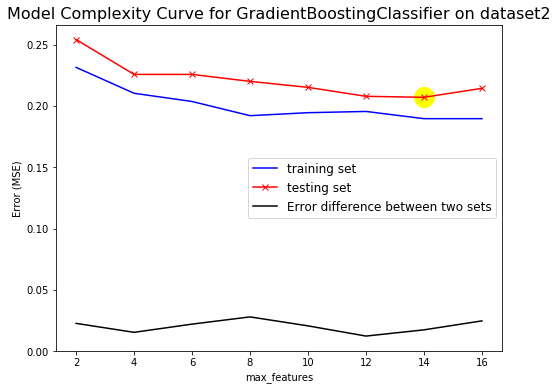

In [57]:
display(name,GBM_res2,pr,pr_l,2,
        [2,4,6,8,10,12,14,16])

# 7. Improved Models  
## 7.1 Dataset1

In [58]:
improved1 = [MLPClassifier(random_state=0,max_iter = 10),
             DecisionTreeClassifier(random_state=0, max_depth = 11),
             KNeighborsClassifier(100),
             SVC(C = 1., kernel = 'linear', probability=True,random_state=0),
             GradientBoostingClassifier(random_state=0,max_depth = 6)]

In [59]:
im_rocauc_results = {}
for clf in improved1:
    clf_name = clf.__class__.__name__
    im_rocauc_results [clf_name] = {'auc':0,'fpr':[],'tpr':[]}
    
    clf.fit(X_train,y_train)
    im_rocauc_results[clf_name]['fpr'],im_rocauc_results [clf_name]['tpr'],_ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    im_rocauc_results[clf_name]['auc'] = auc(im_rocauc_results[clf_name]['fpr'], im_rocauc_results [clf_name]['tpr'])

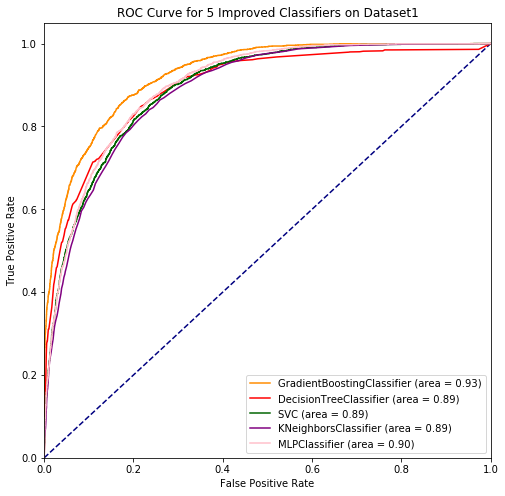

In [60]:
plt.figure(figsize = (8,8))
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')

for i,name in enumerate(im_rocauc_results.keys()):
    plt.plot(im_rocauc_results[name]['fpr'], im_rocauc_results[name]['tpr'], color=colors[i],label='{} (area = {:.2f})'.format(name,im_rocauc_results[name]['auc']))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve for 5 Improved Classifiers on Dataset1');
plt.legend(loc="lower right");  

plt.savefig('7.1 ROC Curve for 5 Improved Classifiers on Dataset1.png')

## 7.2 Dataset2  

In [61]:
improved2 = [MLPClassifier(random_state=0,max_iter = 50),
             DecisionTreeClassifier(random_state=0, max_depth = 4),
             KNeighborsClassifier(100),
             SVC(C = 10000,kernel = 'linear', probability=True,random_state=0),
             GradientBoostingClassifier(random_state=0,max_features = 12, learning_rate = 0.05, subsample = 0.5)]

In [62]:
im_rocauc_results2 = {}
for clf in improved2:
    clf_name = clf.__class__.__name__
    im_rocauc_results2[clf_name] = {'auc':0,'fpr':[],'tpr':[]}
    
    clf.fit(X_train2,y_train2)
    im_rocauc_results2[clf_name]['fpr'],im_rocauc_results2[clf_name]['tpr'],_ = roc_curve(y_test2, clf.predict_proba(X_test2)[:, 1])
    im_rocauc_results2[clf_name]['auc'] = auc(im_rocauc_results2[clf_name]['fpr'], im_rocauc_results2[clf_name]['tpr'])



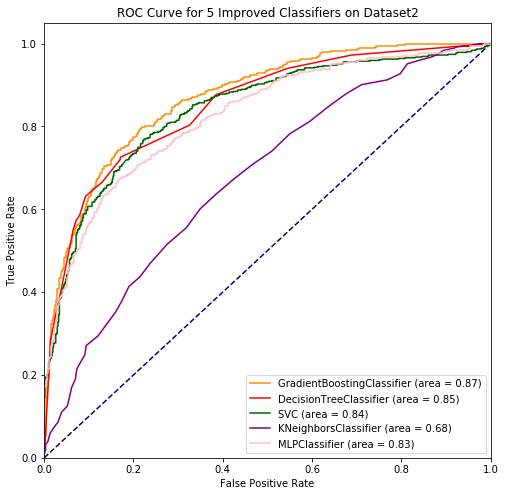

In [63]:
plt.figure(figsize = (8,8))
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')

for i,name in enumerate(im_rocauc_results2.keys()):
    plt.plot(im_rocauc_results2[name]['fpr'], im_rocauc_results2[name]['tpr'], color=colors[i],label='{} (area = {:.2f})'.format(name,im_rocauc_results2[name]['auc']))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve for 5 Improved Classifiers on Dataset2');
plt.legend(loc="lower right");  

plt.savefig('7.2 ROC Curve for 5 Improved Classifiers on Dataset2.png')